In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.utils import shuffle
import os
from PIL import Image  
import time

import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Flatten, Dense, Conv2D, Dropout, MaxPool2D
from tensorflow.keras import optimizers
from keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.losses import CategoricalCrossentropy

%matplotlib inline

In [7]:
def load_data_numpy(dir):
    data_dir = os.join.path(dir, "data.npy") 
    label_dir = os.join.path(dir, "label.npy") 
    return np.load(data_dir), np.load(label_dir)

In [3]:
def load_data_image(dir):
    LABEL_LIST = [10, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    
    X = []
    y_onehot = np.zeros((60000, 10))
    
    for num in range(10):
        sub_dir = os.path.join(dir, str(LABEL_LIST[num]))
        for img_dir in os.listdir(sub_dir):
            img = Image.open(os.path.join(sub_dir, img_dir))
            array_img = np.array(img)
            X.append(np.array(img))
        
        y_onehot[6000*(num):6000*(num+1), num] = 1
    
        # Show example of number
        # img.show(title=str(num+1))
        plt.figure()
        plt.title(str(LABEL_LIST[num]))
        plt.imshow(array_img)
        plt.show()
    
    X = np.reshape(np.array(X), (60000, 28, 28, 1))
    X_shuffle, y_shuffle = shuffle(X, y_onehot, random_state=1)
    
    # np.save('data.npy', X_shuffle)
    # np.save('label.npy', y_shuffle)
    
    return X_shuffle, y_shuffle

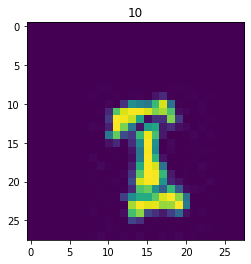

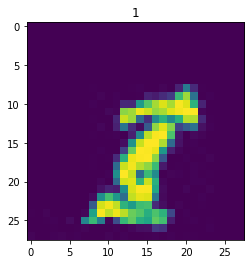

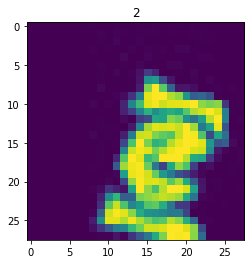

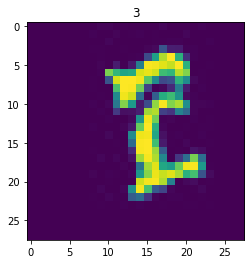

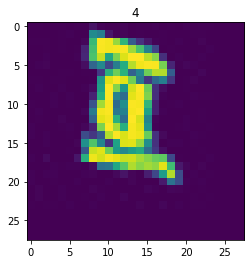

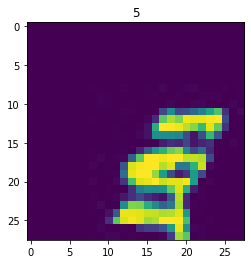

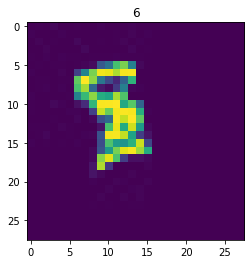

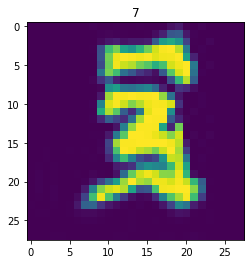

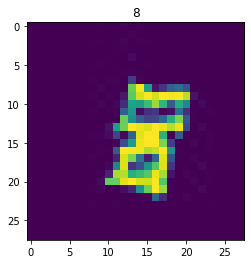

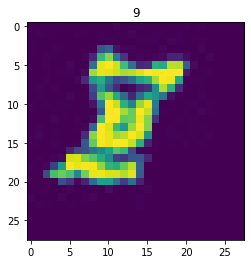

In [4]:
# drive_folder = "/content/drive/My Drive/Colab Notebooks/assignment1_train" 
# X, y = load_data_image(drive_folder)
my_folder = "assignment1_train"
X, y = load_data_image(my_folder)

# Splitting dataset

In [85]:
X_train = X[:50000, :, :] 
y_train = y[:50000, :] 

X_small = X_train[:1000, :, :]
y_small = y[:1000, :] 

X_test = X[50000:, :, :] 
y_test = y[50000:, :] 

In [64]:
model_ann = Sequential([
    Flatten(input_shape=(28,28)),
    Dense(500, activation='relu'),
    Dense(100, activation='relu'),
    Dense(10, activation='softmax')
])
opt_ann = keras.optimizers.Adam(1e-3)
model_ann.compile(optimizer=opt_ann, loss=CategoricalCrossentropy(), metrics=['accuracy'])
model_ann.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_17 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 500)               392500    
_________________________________________________________________
dense_47 (Dense)             (None, 100)               50100     
_________________________________________________________________
dense_48 (Dense)             (None, 10)                1010      
Total params: 443,610
Trainable params: 443,610
Non-trainable params: 0
_________________________________________________________________


In [86]:
model_ann.fit(X_small, y_small, epochs=50, verbose=2)
test_loss, tess_acc = model_ann.evaluate(X_test, y_test)
print("Loss:", test_loss, "Accuracy:", tess_acc)

Epoch 1/50
32/32 - 0s - loss: 2.3008 - accuracy: 0.1150
Epoch 2/50
32/32 - 0s - loss: 2.3008 - accuracy: 0.1150
Epoch 3/50
32/32 - 0s - loss: 2.3008 - accuracy: 0.1150
Epoch 4/50
32/32 - 0s - loss: 2.3008 - accuracy: 0.1150
Epoch 5/50
32/32 - 0s - loss: 2.3008 - accuracy: 0.1150
Epoch 6/50
32/32 - 0s - loss: 2.3008 - accuracy: 0.1150
Epoch 7/50
32/32 - 0s - loss: 2.3008 - accuracy: 0.1150
Epoch 8/50
32/32 - 0s - loss: 2.3008 - accuracy: 0.1150
Epoch 9/50
32/32 - 0s - loss: 2.3008 - accuracy: 0.1150
Epoch 10/50
32/32 - 0s - loss: 2.3008 - accuracy: 0.1150
Epoch 11/50
32/32 - 0s - loss: 2.3008 - accuracy: 0.1150
Epoch 12/50
32/32 - 0s - loss: 2.3008 - accuracy: 0.1150
Epoch 13/50
32/32 - 0s - loss: 2.3008 - accuracy: 0.1150
Epoch 14/50
32/32 - 0s - loss: 2.3009 - accuracy: 0.1150
Epoch 15/50
32/32 - 0s - loss: 2.3008 - accuracy: 0.1150
Epoch 16/50
32/32 - 0s - loss: 2.3008 - accuracy: 0.1150
Epoch 17/50
32/32 - 0s - loss: 2.3009 - accuracy: 0.1150
Epoch 18/50
32/32 - 0s - loss: 2.3008 - 

# CNN

In [91]:
# BatchNormalization()
# MaxPooling2D(strides=2)
# momentum 
# activity_regularizer=l1(1e3)

model_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    #Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    #Dropout(0.25),
    
    Flatten(),
    Dense(512, activation='relu'),
    #Dropout(0.5),
    Dense(10, activation='softmax', activity_regularizer=l2(1e-4))
])
opt_cnn = optimizers.SGD(1e-5)
# default learning_rate = 1e3
model_cnn.compile(optimizer=opt_cnn, loss=CategoricalCrossentropy(), metrics=['accuracy'])
model_cnn.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 26, 26, 32)        9248      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_22 (Flatten)         (None, 1600)            

In [93]:
# model_cnn.fit(X_small, y_small, validation_data=(X_test,y_test), epochs=100, verbose=2)
# test_loss, tess_acc = model_cnn.evaluate(X_test, y_test)
# print("Loss:", test_loss, "Accuracy:", tess_acc)

model_cnn.fit(X, y, validation_split=0.2, epochs=100, verbose=2)  # epochs=150-200

Epoch 1/100
1500/1500 - 146s - loss: 2.9166 - accuracy: 0.1384 - val_loss: 2.6744 - val_accuracy: 0.1499
Epoch 2/100
1500/1500 - 152s - loss: 2.5170 - accuracy: 0.1681 - val_loss: 2.4451 - val_accuracy: 0.1740
Epoch 3/100
1500/1500 - 150s - loss: 2.3456 - accuracy: 0.1947 - val_loss: 2.3142 - val_accuracy: 0.2000
Epoch 4/100
1500/1500 - 147s - loss: 2.2347 - accuracy: 0.2187 - val_loss: 2.2193 - val_accuracy: 0.2224
Epoch 5/100
1500/1500 - 144s - loss: 2.1484 - accuracy: 0.2409 - val_loss: 2.1406 - val_accuracy: 0.2414
Epoch 6/100
1500/1500 - 140s - loss: 2.0742 - accuracy: 0.2641 - val_loss: 2.0732 - val_accuracy: 0.2634
Epoch 7/100
1500/1500 - 149s - loss: 2.0064 - accuracy: 0.2862 - val_loss: 2.0080 - val_accuracy: 0.2838
Epoch 8/100
1500/1500 - 147s - loss: 1.9436 - accuracy: 0.3086 - val_loss: 1.9491 - val_accuracy: 0.3093
Epoch 9/100
1500/1500 - 29883s - loss: 1.8844 - accuracy: 0.3287 - val_loss: 1.8936 - val_accuracy: 0.3268
Epoch 10/100
1500/1500 - 141s - loss: 1.8267 - accura

Epoch 79/100
1500/1500 - 140s - loss: 0.4979 - accuracy: 0.8265 - val_loss: 0.5462 - val_accuracy: 0.8097
Epoch 80/100
1500/1500 - 149s - loss: 0.4921 - accuracy: 0.8274 - val_loss: 0.5439 - val_accuracy: 0.8100
Epoch 81/100
1500/1500 - 151s - loss: 0.4864 - accuracy: 0.8298 - val_loss: 0.5346 - val_accuracy: 0.8156
Epoch 82/100
1500/1500 - 150s - loss: 0.4807 - accuracy: 0.8332 - val_loss: 0.5300 - val_accuracy: 0.8148
Epoch 83/100
1500/1500 - 151s - loss: 0.4755 - accuracy: 0.8339 - val_loss: 0.5244 - val_accuracy: 0.8170
Epoch 84/100
1500/1500 - 138s - loss: 0.4699 - accuracy: 0.8360 - val_loss: 0.5167 - val_accuracy: 0.8197
Epoch 85/100
1500/1500 - 137s - loss: 0.4646 - accuracy: 0.8378 - val_loss: 0.5171 - val_accuracy: 0.8176
Epoch 86/100
1500/1500 - 135s - loss: 0.4595 - accuracy: 0.8387 - val_loss: 0.5081 - val_accuracy: 0.8221
Epoch 87/100
1500/1500 - 134s - loss: 0.4545 - accuracy: 0.8421 - val_loss: 0.5012 - val_accuracy: 0.8253
Epoch 88/100
1500/1500 - 133s - loss: 0.4498 -